In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

# Acknowledgment:
# We express our sincere gratitude to the developers and contributors of the
# DGL library, particularly the example implementation of APPNP available at:
# https://github.com/dmlc/dgl/blob/master/examples/sparse/appnp.py
# This work served as a foundational reference and inspiration for our implementation.


In [2]:
# !pip install torch==2.1.0+cu121 torchvision==0.16.0+cu121 torchaudio==2.1.0+cu121 \
#   --index-url https://download.pytorch.org/whl/cu121
# !pip install dgl==2.4.0+cu121 -f https://data.dgl.ai/wheels/torch-2.1/cu121/repo.html
# !pip install --force-reinstall numpy==1.26.4
# !pip install lime matplotlib scikit-learn

In [3]:
import dgl
import dgl.sparse as dglsp
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss, roc_auc_score
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.manifold import TSNE
import random
import matplotlib.pyplot as plt
import torch.nn.functional as nnF
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Subset
from torch_geometric.data import Data
device = 'cuda' if torch.cuda.is_available() else 'cpu'
from torchvision import models

/home/snu/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/snu/anaconda3/envs/torch_env/lib/python3.10/site-packages/torch_geometric/typing.py:68: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /home/snu/anaconda3/envs/torch_env/lib/python3.10/site-packages/libpyg.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSsb
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/home/snu/anaconda3/envs/torch_env/lib/python3.10/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /home/snu/anaconda3/envs/torch_env/lib/python3.10/site-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSsb
  warnings.warn(f"An is

In [4]:
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
data = np.load('/home/snu/Downloads/pneumoniamnist_224.npz', allow_pickle=True)
all_images = np.concatenate([data['train_images'], data['val_images'], data['test_images']], axis=0)
all_labels = np.concatenate([data['train_labels'], data['val_labels'], data['test_labels']], axis=0).squeeze()

images = all_images.astype(np.float32) / 255.0
images = np.repeat(images[:, None, :, :], 3, axis=1)  # (N,3,224,224)
X = torch.tensor(images)
y = torch.tensor(all_labels).long()
print("Images, labels shapes:", X.shape, y.shape)

Images, labels shapes: torch.Size([5856, 3, 224, 224]) torch.Size([5856])


In [6]:
dataset = TensorDataset(X, y)
class0_indices = [i for i in range(len(y)) if y[i] == 0]
class1_indices = [i for i in range(len(y)) if y[i] == 1]

random.seed(SEED)
sampled_class0 = random.sample(class0_indices, min(2000, len(class0_indices)))
sampled_class1 = random.sample(class1_indices, min(2000, len(class1_indices)))

combined_indices = sampled_class0 + sampled_class1
random.shuffle(combined_indices)

final_dataset = Subset(dataset, combined_indices)
final_loader = DataLoader(final_dataset, batch_size=64, shuffle=False)

In [7]:
resnet = models.resnet18(pretrained=True)
resnet.fc = nn.Identity()
resnet = resnet.to(device)
resnet.eval()

resnet_feats = []
y_list = []
with torch.no_grad():
    for imgs, labels in final_loader:
        imgs = imgs.to(device)
        feats = resnet(imgs)
        resnet_feats.append(feats.cpu())
        y_list.extend(labels.cpu().tolist())

features = torch.cat(resnet_feats, dim=0).numpy().astype(np.float32)
y_labels = np.array(y_list).astype(np.int64)
print("Feature shape:", features.shape, "Label shape:", y_labels.shape)

num_nodes, feat_dim = features.shape

/home/snu/anaconda3/envs/torch_env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/snu/anaconda3/envs/torch_env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Feature shape: (3583, 512) Label shape: (3583,)


In [8]:
import torch.nn.functional as nnF

alpha = 0.9

vit_features = torch.cat(resnet_feats, dim=0).numpy().astype(np.float32)
y = np.array(y_labels).astype(np.int64)

num_nodes, num_feats = vit_features.shape
print(f"Extracted ViT-DINO Features: {vit_features.shape}, Labels: {y.shape}")

X_tensor = torch.tensor(vit_features, dtype=torch.float32).to(device)
y_tensor = torch.tensor(y, dtype=torch.long).to(device)

X_norm = nnF.normalize(X_tensor, p=2, dim=1)
sim_matrix = torch.mm(X_norm, X_norm.T)
src, dst = torch.where(sim_matrix > alpha)
mask = src != dst
src, dst = src[mask], dst[mask]

graph = dgl.graph((src.cpu(), dst.cpu()), num_nodes=num_nodes)
graph = dgl.to_bidirected(graph)
graph = dgl.add_self_loop(graph)

graph = graph.to(device)
print(f"Graph Nodes: {graph.num_nodes()}, Edges: {graph.num_edges()}, Device: {device}")

Extracted ViT-DINO Features: (3583, 512), Labels: (3583,)
Graph Nodes: 3583, Edges: 1642093, Device: cuda


In [9]:
# edge_index = torch.combinations(torch.arange(num_nodes), r=2).T
# src, dst = edge_index
# graph = dgl.graph((src, dst))
# graph = dgl.to_bidirected(graph)
# graph = dgl.add_self_loop(graph)

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# graph = graph.to(device)
# X_tensor = X_tensor.to(device)
# y_tensor = y_tensor.to(device)

# print(f"Graph Nodes: {graph.num_nodes()}, Edges: {graph.num_edges()}, Device: {device}")

In [10]:
class APPNP(nn.Module):
    def __init__(self, in_size, out_size, hidden_size=256, dropout=0.25, num_hops=50, alpha=0.2):
        super().__init__()
        self.f_theta = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(in_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, out_size),
        )
        self.num_hops = num_hops
        self.A_dropout = nn.Dropout(dropout)
        self.alpha = alpha

    def forward(self, A_hat, X):
        Z_0 = Z = self.f_theta(X)
        for _ in range(self.num_hops):
            A_drop = dglsp.val_like(A_hat, self.A_dropout(A_hat.val))
            Z = (1 - self.alpha) * (A_drop @ Z) + self.alpha * Z_0
        return Z

In [11]:
indices = torch.stack(graph.edges())
N = graph.num_nodes()
A = dglsp.spmatrix(indices, shape=(N, N))
I = dglsp.identity(A.shape, device=device)
A_hat = A + I
D_hat = dglsp.diag(A_hat.sum(dim=1)) ** -0.5
A_hat = D_hat @ A_hat @ D_hat

In [12]:
sss = StratifiedShuffleSplit(n_splits=20, test_size=0.9, random_state=42)
num_epochs = 2000

accuracies, precisions, recalls, f1_scores, losses = [], [], [], [], []
all_y_true, all_y_proba, all_fpr, all_tpr, all_auc = [], [], [], [], []

for fold, (train_idx, test_idx) in enumerate(sss.split(vit_features, y)):
    print(f"\n===== Training Fold {fold + 1} =====")

    train_mask = torch.tensor(train_idx, dtype=torch.long).to(device)
    test_mask = torch.tensor(test_idx, dtype=torch.long).to(device)

    normal_train = np.sum(y[train_idx] == 0)
    pneumonia_train = np.sum(y[train_idx] == 1)
    normal_test = np.sum(y[test_idx] == 0)
    pneumonia_test = np.sum(y[test_idx] == 1)

    print(f"Training samples: Normal = {normal_train}, Pneumonia = {pneumonia_train}")
    print(f"Testing samples:  Normal = {normal_test}, Pneumonia = {pneumonia_test}")

    model = APPNP(
        in_size=vit_features.shape[1],
        out_size=2,
        hidden_size=512,
        dropout=0.2
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=5e-4)
    loss_fn = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        out = model(A_hat, X_tensor)
        loss = loss_fn(out[train_mask], y_tensor[train_mask])

        if torch.isnan(loss) or torch.isinf(loss):
            print(f"NaN or Inf loss detected at epoch {epoch}, stopping training.")
            break

        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        logits = model(A_hat, X_tensor)
        y_pred = torch.argmax(logits, dim=1).cpu().numpy()
        y_pred_proba = torch.softmax(logits, dim=1).cpu().numpy()

    y_true_test = y_tensor[test_mask].cpu().numpy()

    accuracy = accuracy_score(y_true_test, y_pred[test_mask.cpu().numpy()])
    precision = precision_score(y_true_test, y_pred[test_mask.cpu().numpy()])
    recall = recall_score(y_true_test, y_pred[test_mask.cpu().numpy()])
    f1 = f1_score(y_true_test, y_pred[test_mask.cpu().numpy()])
    cross_entropy_loss = log_loss(
        y_true_test,
        y_pred_proba[test_mask.cpu().numpy()]
    )

    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)
    losses.append(cross_entropy_loss)

    all_y_true.extend(y_true_test)
    all_y_proba.extend(y_pred_proba[:, 1][test_mask.cpu().numpy()])
    fpr, tpr, _ = roc_curve(
        y_true_test,
        y_pred_proba[:, 1][test_mask.cpu().numpy()]
    )
    all_fpr.append(fpr)
    all_tpr.append(tpr)
    all_auc.append(auc(fpr, tpr))

    print(f"\nFold {fold + 1} Evaluation:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Cross-Entropy Loss: {cross_entropy_loss:.4f}")
    print("-" * 60)

print("\n===== Average Results across 20 Folds =====")
print(f"Accuracy: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")
print(f"Precision: {np.mean(precisions):.4f} ± {np.std(precisions):.4f}")
print(f"Recall: {np.mean(recalls):.4f} ± {np.std(recalls):.4f}")
print(f"F1 Score: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")
print(f"Cross-Entropy Loss: {np.mean(losses):.4f} ± {np.std(losses):.4f}")
print(f"Average AUC: {np.mean(all_auc):.4f} ± {np.std(all_auc):.4f}")



===== Training Fold 1 =====
Training samples: Normal = 158, Pneumonia = 200
Testing samples:  Normal = 1425, Pneumonia = 1800

Fold 1 Evaluation:
Accuracy: 0.9361
Precision: 0.9661
Recall: 0.9178
F1 Score: 0.9413
Cross-Entropy Loss: 0.1821
------------------------------------------------------------

===== Training Fold 2 =====
Training samples: Normal = 158, Pneumonia = 200
Testing samples:  Normal = 1425, Pneumonia = 1800

Fold 2 Evaluation:
Accuracy: 0.9340
Precision: 0.9320
Recall: 0.9511
F1 Score: 0.9414
Cross-Entropy Loss: 0.2000
------------------------------------------------------------

===== Training Fold 3 =====
Training samples: Normal = 158, Pneumonia = 200
Testing samples:  Normal = 1425, Pneumonia = 1800

Fold 3 Evaluation:
Accuracy: 0.9395
Precision: 0.9397
Recall: 0.9528
F1 Score: 0.9462
Cross-Entropy Loss: 0.1557
------------------------------------------------------------

===== Training Fold 4 =====
Training samples: Normal = 158, Pneumonia = 200
Testing samples: 

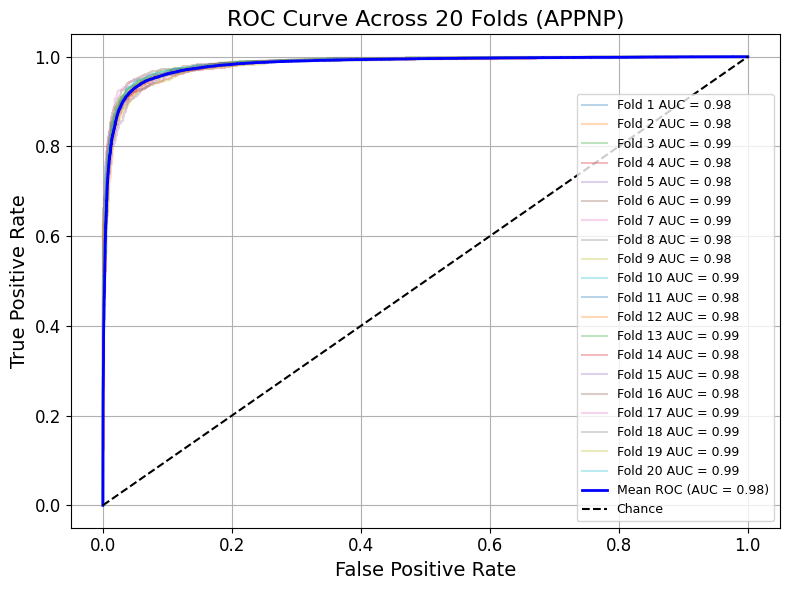

In [13]:
plt.figure(figsize=(8, 6))

for i in range(len(all_fpr)):
    plt.plot(all_fpr[i], all_tpr[i], alpha=0.3, label=f"Fold {i+1} AUC = {all_auc[i]:.2f}")

fpr_avg, tpr_avg, _ = roc_curve(all_y_true, all_y_proba)
auc_avg = roc_auc_score(all_y_true, all_y_proba)
plt.plot(fpr_avg, tpr_avg, color='blue', lw=2, label=f"Mean ROC (AUC = {auc_avg:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label="Chance")

plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate", fontsize=14)
plt.title("ROC Curve Across 20 Folds (APPNP)", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc="lower right", fontsize=9)
plt.grid(True)
plt.tight_layout()
plt.show()

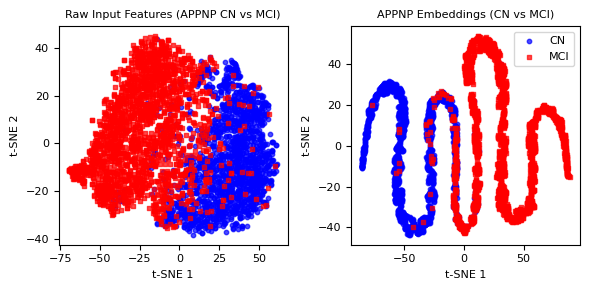

In [14]:
X_input = X_tensor.cpu().numpy()
tsne_input = TSNE(n_components=2, init='pca', random_state=42)
input_2d = tsne_input.fit_transform(X_input)

model.eval()
with torch.no_grad():
    # Get final APPNP embeddings (after propagation)
    Z = model(A_hat, X_tensor).cpu().numpy()

tsne_embed = TSNE(n_components=2, init='pca', random_state=42)
embed_2d = tsne_embed.fit_transform(Z)

labels = y_tensor.cpu().numpy()

colors = ['blue', 'red']
markers = ['o', 's']
class_names = ['CN', 'MCI']
font_size = 8

fig, axes = plt.subplots(1, 2, figsize=(6, 3))

# Plot raw input t-SNE
for cls, color, marker in zip([0, 1], colors, markers):
    idx = labels == cls
    axes[0].scatter(input_2d[idx, 0], input_2d[idx, 1],
                    c=color, marker=marker, label=class_names[cls], alpha=0.7, s=10)
axes[0].set_title("Raw Input Features (APPNP CN vs MCI)", fontsize=font_size)
axes[0].set_xlabel("t-SNE 1", fontsize=font_size)
axes[0].set_ylabel("t-SNE 2", fontsize=font_size)
axes[0].tick_params(labelsize=font_size)

# Plot APPNP embeddings t-SNE
for cls, color, marker in zip([0, 1], colors, markers):
    idx = labels == cls
    axes[1].scatter(embed_2d[idx, 0], embed_2d[idx, 1],
                    c=color, marker=marker, label=class_names[cls], alpha=0.7, s=10)
axes[1].set_title("APPNP Embeddings (CN vs MCI)", fontsize=font_size)
axes[1].set_xlabel("t-SNE 1", fontsize=font_size)
axes[1].set_ylabel("t-SNE 2", fontsize=font_size)
axes[1].tick_params(labelsize=font_size)
axes[1].legend(fontsize=font_size, loc='best')

plt.tight_layout()
plt.savefig("tsne_appnp_comparison.png", dpi=300, bbox_inches='tight')
plt.show()
